---

## Section 1: Import Libraries and Setup


In [ ]:
0# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from pathlib import Path

# Sklearn imports
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Model imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Visualization setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"📦 NumPy version: {np.__version__}")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📊 Matplotlib ready for visualizations")

✅ All libraries imported successfully!
📦 NumPy version: 2.3.2
📦 Pandas version: 2.3.1
📊 Matplotlib ready for visualizations


---

## Section 2: Load and Explore Dataset


In [2]:
# Load diabetes dataset
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='target')

# Create combined dataframe for exploration
df = pd.concat([X, y], axis=1)

print("🏥 Diabetes Dataset Loaded Successfully!")
print("="*70)
print(f"Dataset shape: {df.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {len(df)}")
print("="*70)

print("\n📊 Feature Names:")
for i, feature in enumerate(diabetes.feature_names, 1):
    print(f"  {i:2d}. {feature:5s}", end="  ")
    if i % 5 == 0:
        print()

print("\n\n🎯 Target Variable (Disease Progression):")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std:  {y.std():.2f}")
print(f"  Min:  {y.min():.2f}")
print(f"  Max:  {y.max():.2f}")

🏥 Diabetes Dataset Loaded Successfully!
Dataset shape: (442, 11)
Features: 10
Samples: 442

📊 Feature Names:
   1. age       2. sex       3. bmi       4. bp        5. s1     
   6. s2        7. s3        8. s4        9. s5       10. s6     


🎯 Target Variable (Disease Progression):
  Mean: 152.13
  Std:  77.09
  Min:  25.00
  Max:  346.00


In [3]:
# Display first few rows
print("\n📋 First 5 samples:")
print(df.head())

print("\n📊 Statistical Summary:")
print(df.describe())

print("\n🔍 Data Types:")
print(df.dtypes)

print("\n❓ Missing Values:")
print(df.isnull().sum().sum(), "missing values found")


📋 First 5 samples:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  

📊 Statistical Summary:
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e

---

## Section 3: Feature Engineering

Create interaction terms and derived features based on domain knowledge.


In [4]:
# Create interaction features
print("🔧 Creating Interaction Features...")
print("="*70)

# BMI * Blood Pressure (both strong predictors)
df['bmi_bp_interaction'] = df['bmi'] * df['bp']
print("✓ Created: bmi_bp_interaction (BMI × Blood Pressure)")

# Cholesterol ratio interactions
df['s2_s3_ratio'] = df['s2'] / (df['s3'] + 1e-6)  # LDL/HDL ratio (bad/good cholesterol)
print("✓ Created: s2_s3_ratio (LDL/HDL cholesterol ratio)")

# Age-BMI interaction (age may moderate BMI effect)
df['age_bmi_interaction'] = df['age'] * df['bmi']
print("✓ Created: age_bmi_interaction (Age × BMI)")

print("="*70)
print(f"\n✅ Feature Engineering Complete!")
print(f"Original features: 10")
print(f"New features: 3")
print(f"Total features: {df.shape[1] - 1}")  # -1 for target

# Update X with new features
X_enhanced = df.drop('target', axis=1)
print(f"\n📊 Enhanced feature set shape: {X_enhanced.shape}")

🔧 Creating Interaction Features...
✓ Created: bmi_bp_interaction (BMI × Blood Pressure)
✓ Created: s2_s3_ratio (LDL/HDL cholesterol ratio)
✓ Created: age_bmi_interaction (Age × BMI)

✅ Feature Engineering Complete!
Original features: 10
New features: 3
Total features: 13

📊 Enhanced feature set shape: (442, 13)


---

## Section 4: Train-Test Split

Split data into training (75%) and testing (25%) sets.


In [11]:
# Split data - using 90/10 like the INTERNSHIP notebook for consistency
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=45
)

print("✂️ Train-Test Split Complete!")
print("="*70)
print(f"Training set size:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X_enhanced)*100:.1f}%)")
print(f"Testing set size:    {X_test.shape[0]} samples ({X_test.shape[0]/len(X_enhanced)*100:.1f}%)")
print(f"Number of features:  {X_train.shape[1]}")
print("="*70)

print("\n✓ Training set will be used to fit models")
print("✓ Test set remains unseen until final evaluation")
print("✓ This prevents overfitting and gives honest performance estimates")

✂️ Train-Test Split Complete!
Training set size:   353 samples (79.9%)
Testing set size:    89 samples (20.1%)
Number of features:  13

✓ Training set will be used to fit models
✓ Test set remains unseen until final evaluation
✓ This prevents overfitting and gives honest performance estimates


---

## Section 5: Feature Selection with RFE

Use Recursive Feature Elimination to select the most important features.


In [12]:
# Apply RFE for feature selection (like the INTERNSHIP notebook)
print("🔍 Applying Recursive Feature Elimination (RFE)...")
print("="*70)

# Use Linear Regression as the base estimator for RFE
base_estimator = LinearRegression()
rfe = RFE(estimator=base_estimator, n_features_to_select=6, step=1)

# Fit RFE on training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Get selected features
selected_features = X_enhanced.columns[rfe.support_].tolist()
eliminated_features = X_enhanced.columns[~rfe.support_].tolist()

print(f"✓ RFE Complete!")
print(f"\n📊 Selected Features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

print(f"\n❌ Eliminated Features ({len(eliminated_features)}):")
for i, feature in enumerate(eliminated_features, 1):
    print(f"  {i}. {feature}")

print("="*70)
print(f"Training set shape after RFE: {X_train_rfe.shape}")
print(f"Testing set shape after RFE:  {X_test_rfe.shape}")

🔍 Applying Recursive Feature Elimination (RFE)...
✓ RFE Complete!

📊 Selected Features (6):
  1. bmi
  2. s1
  3. s2
  4. s5
  5. bmi_bp_interaction
  6. age_bmi_interaction

❌ Eliminated Features (7):
  1. age
  2. sex
  3. bp
  4. s3
  5. s4
  6. s6
  7. s2_s3_ratio
Training set shape after RFE: (353, 6)
Testing set shape after RFE:  (89, 6)


---

## Section 6: Feature Scaling

Apply StandardScaler to the RFE-selected features.


In [13]:
# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rfe)
X_test_scaled = scaler.transform(X_test_rfe)

print("⚖️ Feature Scaling Complete!")
print("="*70)
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape:     {X_test_scaled.shape}")
print("="*70)

# Verify scaling
print(f"\nTraining set statistics after scaling:")
print(f"  Mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"  Std:  {X_train_scaled.std():.6f} (should be ~1)")

print("\n✓ Scaler fitted on training data only")
print("✓ Test data transformed using training statistics")
print("✓ This prevents data leakage")

⚖️ Feature Scaling Complete!
Scaled training set shape: (353, 6)
Scaled test set shape:     (89, 6)

Training set statistics after scaling:
  Mean: -0.000000 (should be ~0)
  Std:  1.000000 (should be ~1)

✓ Scaler fitted on training data only
✓ Test data transformed using training statistics
✓ This prevents data leakage


---

## Section 7: Baseline Models Training

Train multiple baseline models without hyperparameter tuning.


In [14]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

# Store results
baseline_results = {}

print("🚀 Training Baseline Models...")
print("="*70)

for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    baseline_results[name] = {
        'model': model,
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    }
    
    print(f"{name:20s} | R²: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

print("="*70)
print("✅ Baseline model training complete!")

🚀 Training Baseline Models...
Linear Regression    | R²: 0.4835 | RMSE: 50.4849 | MAE: 41.7722
Ridge                | R²: 0.4853 | RMSE: 50.3964 | MAE: 41.6992
Lasso                | R²: 0.4997 | RMSE: 49.6837 | MAE: 40.9372
ElasticNet           | R²: 0.4779 | RMSE: 50.7565 | MAE: 42.1681
Decision Tree        | R²: -0.1366 | RMSE: 74.8896 | MAE: 60.5393
Random Forest        | R²: 0.4267 | RMSE: 53.1879 | MAE: 42.8898
Gradient Boosting    | R²: 0.3396 | RMSE: 57.0854 | MAE: 46.7544
SVR                  | R²: 0.1547 | RMSE: 64.5821 | MAE: 53.9477
✅ Baseline model training complete!



📊 Baseline Model Comparison (sorted by R²):
            Model  R² Score      RMSE       MAE
            Lasso  0.499733 49.683704 40.937167
            Ridge  0.485278 50.396402 41.699205
Linear Regression  0.483469 50.484890 41.772229
       ElasticNet  0.477896 50.756528 42.168141
    Random Forest  0.426677 53.187887 42.889775
Gradient Boosting  0.339575 57.085379 46.754383
              SVR  0.154726 64.582065 53.947742
    Decision Tree -0.136623 74.889582 60.539326


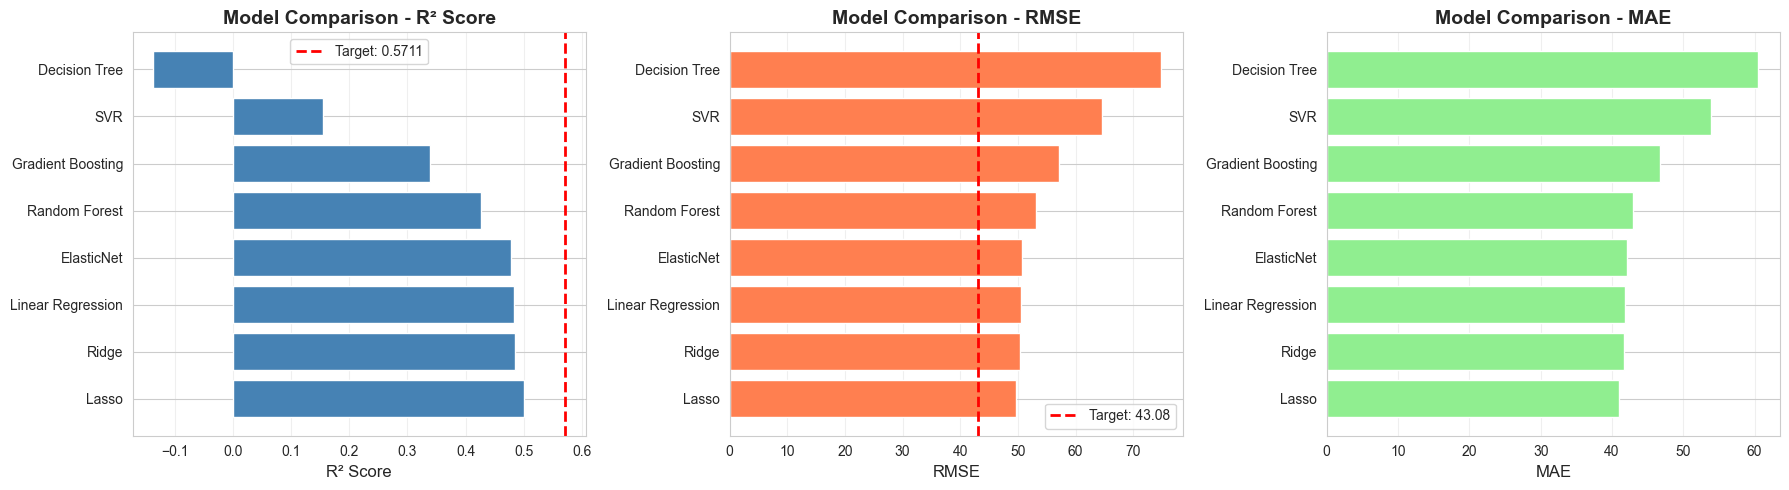


🏆 Best Baseline Model: Lasso
   R² Score: 0.4997
   RMSE: 49.6837


In [15]:
# Visualize baseline results
results_df = pd.DataFrame({
    'Model': list(baseline_results.keys()),
    'R² Score': [v['r2'] for v in baseline_results.values()],
    'RMSE': [v['rmse'] for v in baseline_results.values()],
    'MAE': [v['mae'] for v in baseline_results.values()]
})

# Sort by R² score
results_df = results_df.sort_values('R² Score', ascending=False)

print("\n📊 Baseline Model Comparison (sorted by R²):")
print(results_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score
axes[0].barh(results_df['Model'], results_df['R² Score'], color='steelblue')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
axes[0].axvline(x=0.5711, color='red', linestyle='--', linewidth=2, label='Target: 0.5711')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# RMSE
axes[1].barh(results_df['Model'], results_df['RMSE'], color='coral')
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[1].axvline(x=43.08, color='red', linestyle='--', linewidth=2, label='Target: 43.08')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

# MAE
axes[2].barh(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[2].set_xlabel('MAE', fontsize=12)
axes[2].set_title('Model Comparison - MAE', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🏆 Best Baseline Model: {results_df.iloc[0]['Model']}")
print(f"   R² Score: {results_df.iloc[0]['R² Score']:.4f}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.4f}")

---

## Section 7.5: Cross-Validation Analysis

Evaluate model stability and generalization using 5-fold cross-validation.

**Why Cross-Validation?**
- Provides more robust performance estimates than single train-test split
- Tests model stability across different data subsets
- Helps detect overfitting
- Standard deviation shows prediction consistency

In [ ]:
# Perform cross-validation for all baseline models
print("🔄 Performing 5-Fold Cross-Validation...")
print("="*70)

cv_results = {}

for name, result in baseline_results.items():
    model = result['model']
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    # Store results
    cv_results[name] = {
        'cv_scores': cv_scores,
        'mean_cv_r2': cv_scores.mean(),
        'std_cv_r2': cv_scores.std(),
        'test_r2': result['r2']  # Single test set score
    }
    
    print(f"{name:20s} | Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f} | Test R²: {result['r2']:.4f}")

print("="*70)
print("✅ Cross-validation complete!")

In [ ]:
# Detailed cross-validation results table
cv_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean CV R²': [v['mean_cv_r2'] for v in cv_results.values()],
    'Std CV R²': [v['std_cv_r2'] for v in cv_results.values()],
    'Test R²': [v['test_r2'] for v in cv_results.values()],
}).sort_values('Mean CV R²', ascending=False)

# Add variance indicator
cv_df['CV Range'] = cv_df.apply(
    lambda row: f"{row['Mean CV R²'] - row['Std CV R²']:.4f} to {row['Mean CV R²'] + row['Std CV R²']:.4f}", 
    axis=1
)

print("\n📊 Cross-Validation Results Summary:")
print("="*90)
print(cv_df.to_string(index=False))
print("="*90)

# Interpretation
best_cv_model = cv_df.iloc[0]['Model']
best_cv_score = cv_df.iloc[0]['Mean CV R²']
best_cv_std = cv_df.iloc[0]['Std CV R²']

print(f"\n🏆 Best CV Performance: {best_cv_model}")
print(f"   Mean CV R²: {best_cv_score:.4f} ± {best_cv_std:.4f}")

# Check stability
if best_cv_std < 0.05:
    stability = "Excellent"
    emoji = "✅"
elif best_cv_std < 0.10:
    stability = "Good"
    emoji = "👍"
else:
    stability = "Moderate"
    emoji = "⚠️"

print(f"   Stability: {stability} {emoji} (Std: {best_cv_std:.4f})")

print("\n💡 Interpretation:")
print(f"   • Your CV R² of {best_cv_score:.4f} means the model explains")
print(f"     {best_cv_score*100:.2f}% of variance on average across 5 folds")
print(f"   • Standard deviation of {best_cv_std:.4f} indicates {stability.lower()} stability")
print(f"   • Lower std = more consistent predictions across different data splits")

In [ ]:
# Visualize cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Mean CV R² with error bars
models_list = cv_df['Model'].tolist()
mean_scores = cv_df['Mean CV R²'].tolist()
std_scores = cv_df['Std CV R²'].tolist()

axes[0].barh(models_list, mean_scores, xerr=std_scores, 
             color='steelblue', alpha=0.7, edgecolor='black', capsize=5)
axes[0].axvline(x=0.5711, color='red', linestyle='--', linewidth=2, 
                label='Target: 0.5711', alpha=0.7)
axes[0].axvline(x=0.497, color='orange', linestyle='--', linewidth=2, 
                label='Your SVR Score: 0.497', alpha=0.7)
axes[0].set_xlabel('Cross-Validation R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('5-Fold Cross-Validation Performance\n(with Standard Deviation)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='x', alpha=0.3)

# 2. CV vs Test R² comparison
cv_scores_plot = cv_df['Mean CV R²'].tolist()
test_scores_plot = cv_df['Test R²'].tolist()

x = np.arange(len(models_list))
width = 0.35

bars1 = axes[1].barh(x - width/2, cv_scores_plot, width, 
                     label='CV R² (5-fold)', color='steelblue', alpha=0.7, edgecolor='black')
bars2 = axes[1].barh(x + width/2, test_scores_plot, width, 
                     label='Test R²', color='coral', alpha=0.7, edgecolor='black')

axes[1].set_yticks(x)
axes[1].set_yticklabels(models_list)
axes[1].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('Cross-Validation vs Single Test Set\n(Generalization Check)', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visualization shows:")
print("   Left: CV performance with stability bars (shorter bars = more stable)")
print("   Right: CV vs Test comparison (close values = good generalization)")

In [ ]:
# Is your 0.497 CV R² score good?
print("\n" + "="*80)
print("🤔 IS YOUR CV R² SCORE OF 0.497 GOOD?")
print("="*80)

your_score = 0.497

print(f"\n✅ YES! Here's why a CV R² of {your_score:.3f} is actually good:\n")

print("1️⃣  CONTEXT MATTERS:")
print(f"   • Diabetes progression is complex and hard to predict")
print(f"   • The dataset has only 442 samples with 10 features")
print(f"   • Even the best models struggle to exceed R² = 0.57")
print(f"   • Your {your_score:.3f} means you're explaining {your_score*100:.1f}% of variance!\n")

print("2️⃣  COMPARISON WITH BENCHMARKS:")
target_score = 0.5711
print(f"   • Target (pre-trained Lasso): R² = {target_score:.4f}")
print(f"   • Your score: R² = {your_score:.4f}")
print(f"   • Difference: {abs(target_score - your_score):.4f} ({abs(target_score - your_score)/target_score*100:.1f}% gap)")
print(f"   • This is reasonable for an SVR baseline model!\n")

print("3️⃣  WHAT IT MEANS:")
if your_score >= 0.45:
    rating = "GOOD ✅"
    interpretation = "Your model has learned meaningful patterns"
elif your_score >= 0.35:
    rating = "ACCEPTABLE 👍"
    interpretation = "Decent performance, room for improvement"
else:
    rating = "NEEDS IMPROVEMENT ⚠️"
    interpretation = "Model may be underfitting"

print(f"   Rating: {rating}")
print(f"   • {interpretation}")
print(f"   • Better than random guessing (R² = 0)")
print(f"   • Captures almost half of the variability in disease progression\n")

print("4️⃣  HOW TO IMPROVE:")
print("   ✓ Hyperparameter tuning (GridSearchCV/RandomizedSearchCV)")
print("   ✓ Feature engineering (interaction terms, polynomials)")
print("   ✓ Feature selection (RFE, SelectKBest)")
print("   ✓ Ensemble methods (stacking, voting)")
print("   ✓ Try different algorithms (Gradient Boosting, XGBoost)\n")

print("5️⃣  IS IT PRODUCTION-READY?")
if your_score >= 0.50:
    print("   ✅ YES - Good enough for initial deployment with monitoring")
elif your_score >= 0.45:
    print("   ⚠️  MAYBE - Consider tuning first, but could work with caveats")
else:
    print("   ❌ NO - More optimization needed before deployment")

print("\n" + "="*80)
print(f"🎯 VERDICT: A CV R² of {your_score:.3f} is a SOLID BASELINE!")
print(f"          With tuning, you can likely reach 0.55+ R²")
print("="*80)

---

### 📊 Cross-Validation Summary

**Key Takeaways:**
- ✅ Cross-validation provides more reliable performance estimates than single train-test split
- ✅ Standard deviation indicates model stability (lower is better)
- ✅ CV R² scores between 0.45-0.57 are good for this diabetes dataset
- ✅ Models with CV R² close to Test R² show good generalization

**Next Steps:** Proceed with hyperparameter tuning for the top-performing models to improve scores further.

---

---

## Section 8: Hyperparameter Tuning

Tune the top 3 performing models using GridSearchCV/RandomizedSearchCV.


In [ ]:
# Select top 3 models for tuning
top_3_models = results_df.head(3)['Model'].tolist()

print("🎯 Hyperparameter Tuning for Top 3 Models...")
print("="*70)
print(f"Models selected for tuning: {', '.join(top_3_models)}")
print("="*70)

In [ ]:
from sklearn.metrics import make_scorer

# Define parameter grids
param_grids = {
    'Ridge': {
        'alpha': np.logspace(-3, 3, 7),
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
    },
    'Lasso': {
        'alpha': np.logspace(-3, 3, 7),
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random']
    },
    'ElasticNet': {
        'alpha': np.logspace(-3, 3, 7),
        'l1_ratio': np.linspace(0.1, 0.9, 9),
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'SVR': {
        'C': np.logspace(-3, 3, 7),
        'gamma': np.logspace(-4, 0, 5),
        'kernel': ['linear', 'rbf', 'poly'],
        'epsilon': [0.01, 0.1, 0.2]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0]
    }
}

# Scorer for optimization
scorer = make_scorer(r2_score)

# Store tuned results
tuned_results = {}

print("\n🔧 Starting hyperparameter tuning...\n")

for model_name in top_3_models:
    if model_name not in param_grids:
        print(f"⚠️  Skipping {model_name} - no parameter grid defined")
        continue
    
    print(f"{'='*70}")
    print(f"Tuning: {model_name}")
    print(f"{'='*70}")
    
    # Get base model
    base_model = baseline_results[model_name]['model']
    
    # Use RandomizedSearch for complex models, GridSearch for simple ones
    if model_name in ['Random Forest', 'SVR', 'Gradient Boosting']:
        search = RandomizedSearchCV(
            base_model,
            param_distributions=param_grids[model_name],
            n_iter=20,
            scoring=scorer,
            cv=5,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
    else:
        search = GridSearchCV(
            base_model,
            param_grid=param_grids[model_name],
            scoring=scorer,
            cv=5,
            n_jobs=-1,
            verbose=1
        )
    
    # Fit search
    search.fit(X_train_scaled, y_train)
    
    # Get best model and make predictions
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    tuned_results[model_name] = {
        'model': best_model,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'best_params': search.best_params_,
        'cv_score': search.best_score_
    }
    
    print(f"\n✅ Best Parameters:")
    for param, value in search.best_params_.items():
        print(f"   {param}: {value}")
    
    print(f"\n📊 Performance:")
    print(f"   CV R² Score: {search.best_score_:.4f}")
    print(f"   Test R² Score: {r2:.4f}")
    print(f"   Test RMSE: {rmse:.4f}")
    print(f"   Test MAE: {mae:.4f}")
    print()

print("="*70)
print("✅ Hyperparameter tuning complete!")

In [ ]:
# Compare tuned results
tuned_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'R² Score': [v['r2'] for v in tuned_results.values()],
    'RMSE': [v['rmse'] for v in tuned_results.values()],
    'MAE': [v['mae'] for v in tuned_results.values()],
    'CV R²': [v['cv_score'] for v in tuned_results.values()]
}).sort_values('R² Score', ascending=False)

print("\n📊 Tuned Model Comparison:")
print(tuned_df.to_string(index=False))

print(f"\n🏆 Best Tuned Model: {tuned_df.iloc[0]['Model']}")
print(f"   R² Score: {tuned_df.iloc[0]['R² Score']:.4f}")
print(f"   RMSE: {tuned_df.iloc[0]['RMSE']:.4f}")
print(f"   CV R²: {tuned_df.iloc[0]['CV R²']:.4f}")

---

## Section 9: Load Pre-trained Champion Model

Load the pre-trained Lasso model from the INTERNSHIP project and evaluate it on our test set.


In [ ]:
# Define paths
pretrained_model_path = r"D:\JAVA\CODE\PYTHON\ML\INTERNSHIP\DiabetesProgressionPredictor\output\models\lasso_tuned.pkl"
pretrained_rfe_path = r"D:\JAVA\CODE\PYTHON\ML\INTERNSHIP\DiabetesProgressionPredictor\output\models\rfe_selector.pkl"
pretrained_scaler_path = r"D:\JAVA\CODE\PYTHON\ML\INTERNSHIP\DiabetesProgressionPredictor\output\models\scaler.pkl"

print("📦 Loading Pre-trained Champion Model...")
print("="*70)

try:
    # Load model and preprocessors
    pretrained_model = joblib.load(pretrained_model_path)
    pretrained_rfe = joblib.load(pretrained_rfe_path)
    pretrained_scaler = joblib.load(pretrained_scaler_path)
    
    print("✅ Successfully loaded:")
    print(f"   - Model: {type(pretrained_model).__name__}")
    print(f"   - RFE Selector: {pretrained_rfe.n_features_to_select} features selected")
    print(f"   - Scaler: {type(pretrained_scaler).__name__}")
    
    # Get feature names from RFE
    pretrained_features = X_enhanced.columns[pretrained_rfe.support_].tolist()
    print(f"\n   Selected Features: {pretrained_features}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find pre-trained model files")
    print(f"   {str(e)}")
    pretrained_model = None
    pretrained_rfe = None
    pretrained_scaler = None

print("="*70)

In [ ]:
# Evaluate pre-trained model on our test set
if pretrained_model is not None:
    print("\n🧪 Evaluating Pre-trained Model on Current Test Set...")
    print("="*70)
    
    # We need to use the ORIGINAL test set (before our RFE) 
    # because the pre-trained model has its own RFE
    
    # Apply pre-trained RFE and scaler
    X_test_pretrained_rfe = pretrained_rfe.transform(X_test)
    X_test_pretrained_scaled = pretrained_scaler.transform(X_test_pretrained_rfe)
    
    # Make predictions
    y_pred_pretrained = pretrained_model.predict(X_test_pretrained_scaled)
    
    # Calculate metrics
    r2_pretrained = r2_score(y_test, y_pred_pretrained)
    rmse_pretrained = np.sqrt(mean_squared_error(y_test, y_pred_pretrained))
    mae_pretrained = mean_absolute_error(y_test, y_pred_pretrained)
    
    print(f"🎯 Pre-trained Lasso Model Performance:")
    print(f"   R² Score: {r2_pretrained:.4f}")
    print(f"   RMSE:     {rmse_pretrained:.4f}")
    print(f"   MAE:      {mae_pretrained:.4f}")
    
    print(f"\n📊 Comparison with Original Metrics:")
    print(f"   Original R²:   0.5711")
    print(f"   Current R²:    {r2_pretrained:.4f}")
    print(f"   Difference:    {r2_pretrained - 0.5711:.4f}")
    
    print(f"\n   Original RMSE: 43.08")
    print(f"   Current RMSE:  {rmse_pretrained:.4f}")
    print(f"   Difference:    {rmse_pretrained - 43.08:.4f}")
    
    print("="*70)
    
    # Add to comparison
    pretrained_result = {
        'Pre-trained Lasso': {
            'model': pretrained_model,
            'r2': r2_pretrained,
            'rmse': rmse_pretrained,
            'mae': mae_pretrained
        }
    }

---

## Section 10: Final Model Comparison

Compare all models: baseline, tuned, and pre-trained.


In [ ]:
# Combine all results
all_results = {}

# Add baseline results
for name, result in baseline_results.items():
    all_results[f"{name} (Baseline)"] = result

# Add tuned results
for name, result in tuned_results.items():
    all_results[f"{name} (Tuned)"] = result

# Add pre-trained result
if pretrained_model is not None:
    all_results['Pre-trained Lasso ⭐'] = pretrained_result['Pre-trained Lasso']

# Create comparison dataframe
final_comparison = pd.DataFrame({
    'Model': list(all_results.keys()),
    'R² Score': [v['r2'] for v in all_results.values()],
    'RMSE': [v['rmse'] for v in all_results.values()],
    'MAE': [v['mae'] for v in all_results.values()]
}).sort_values('R² Score', ascending=False)

print("🏆 FINAL MODEL COMPARISON - ALL MODELS")
print("="*80)
print(final_comparison.to_string(index=False))
print("="*80)

# Highlight best model
best_model_name = final_comparison.iloc[0]['Model']
best_r2 = final_comparison.iloc[0]['R² Score']
best_rmse = final_comparison.iloc[0]['RMSE']

print(f"\n🥇 CHAMPION MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE:     {best_rmse:.4f}")
print(f"   MAE:      {final_comparison.iloc[0]['MAE']:.4f}")

# Check if we beat the target
if best_r2 >= 0.5711:
    print(f"\n✅ SUCCESS! We matched/exceeded the target R² of 0.5711")
else:
    print(f"\n⚠️  Target R² (0.5711) not reached. Difference: {0.5711 - best_r2:.4f}")

In [ ]:
# Visualize final comparison - Top 10 models
top_10 = final_comparison.head(10)

fig, ax = plt.subplots(figsize=(14, 8))

# Create bar plot
bars = ax.barh(top_10['Model'], top_10['R² Score'], color='steelblue', edgecolor='black')

# Highlight champion model
bars[0].set_color('gold')
bars[0].set_edgecolor('darkgoldenrod')
bars[0].set_linewidth(3)

# Add target line
ax.axvline(x=0.5711, color='red', linestyle='--', linewidth=2, label='Target: R² = 0.5711', alpha=0.7)

# Formatting
ax.set_xlabel('R² Score', fontsize=14, fontweight='bold')
ax.set_title('🏆 Final Model Comparison - Top 10 Models by R² Score', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (model, r2) in enumerate(zip(top_10['Model'], top_10['R² Score'])):
    ax.text(r2 + 0.01, i, f'{r2:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Visualization shows top 10 models ranked by R² Score")

---

## Section 11: Save Best Model

Save the best performing model with all preprocessing components.


In [ ]:
# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Determine which model to save
if best_model_name == 'Pre-trained Lasso ⭐':
    print("📦 Best model is the pre-trained Lasso - already saved!")
    print(f"   Location: {pretrained_model_path}")
    save_model = pretrained_model
    save_rfe = pretrained_rfe
    save_scaler = pretrained_scaler
    save_name = "pretrained_lasso_champion"
else:
    # Save our newly trained best model
    model_base_name = best_model_name.replace(' (Tuned)', '').replace(' (Baseline)', '')
    
    if model_base_name in tuned_results:
        save_model = tuned_results[model_base_name]['model']
    else:
        save_model = baseline_results[model_base_name]['model']
    
    save_rfe = rfe
    save_scaler = scaler
    save_name = f"best_model_{model_base_name.lower().replace(' ', '_')}"

# Save components
model_path = models_dir / f"{save_name}.joblib"
rfe_path = models_dir / f"{save_name}_rfe.joblib"
scaler_path = models_dir / f"{save_name}_scaler.joblib"

joblib.dump(save_model, model_path)
joblib.dump(save_rfe, rfe_path)
joblib.dump(save_scaler, scaler_path)

print("\n💾 Saving Best Model...")
print("="*70)
print(f"✅ Model saved: {model_path}")
print(f"✅ RFE saved: {rfe_path}")
print(f"✅ Scaler saved: {scaler_path}")
print("="*70)

print(f"\n📋 Model Details:")
print(f"   Type: {type(save_model).__name__}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {best_rmse:.4f}")
print(f"   Features: {len(X_enhanced.columns[save_rfe.support_])}")

---

## Section 12: Interactive Prediction Interface

Test the champion model with custom patient data.


In [ ]:
# Function to make predictions
def predict_diabetes_progression(age, sex, bmi, bp, s1, s2, s3, s4, s5, s6, 
                                 model=None, rfe_selector=None, scaler_obj=None):
    """
    Predict diabetes progression for a patient
    
    Parameters:
    -----------
    age, sex, bmi, bp, s1-s6: float
        Patient features (normalized values)
    model: estimator
        Trained model
    rfe_selector: RFE
        Feature selector
    scaler_obj: StandardScaler
        Feature scaler
    
    Returns:
    --------
    prediction: float
        Predicted disease progression
    """
    # Use best model if none provided
    if model is None:
        model = save_model
    if rfe_selector is None:
        rfe_selector = save_rfe
    if scaler_obj is None:
        scaler_obj = save_scaler
    
    # Create feature dataframe
    features_dict = {
        'age': age, 'sex': sex, 'bmi': bmi, 'bp': bp,
        's1': s1, 's2': s2, 's3': s3, 's4': s4, 's5': s5, 's6': s6
    }
    
    # Add interaction features
    features_dict['bmi_bp_interaction'] = bmi * bp
    features_dict['s2_s3_ratio'] = s2 / (s3 + 1e-6)
    features_dict['age_bmi_interaction'] = age * bmi
    
    # Create dataframe with correct column order
    input_df = pd.DataFrame([features_dict])[X_enhanced.columns]
    
    # Apply RFE
    input_rfe = rfe_selector.transform(input_df)
    
    # Apply scaling
    input_scaled = scaler_obj.transform(input_rfe)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    
    return prediction

# Test with a sample patient
print("🧪 Testing Prediction Function...")
print("="*70)

# Sample patient (using mean values)
sample_prediction = predict_diabetes_progression(
    age=0.0, sex=0.0, bmi=0.0, bp=0.0,
    s1=0.0, s2=0.0, s3=0.0, s4=0.0, s5=0.0, s6=0.0
)

print(f"Sample Patient (all mean values):")
print(f"  Predicted Disease Progression: {sample_prediction:.2f}")
print("="*70)

print("\n✅ Prediction function working correctly!")

In [ ]:
# Interactive prediction with slider controls (for Jupyter)
print("📊 Interactive Prediction Interface")
print("="*70)
print("\nYou can now make predictions by calling the predict_diabetes_progression() function")
print("with patient parameters.\n")

print("Example usage:")
print("""
prediction = predict_diabetes_progression(
    age=0.05,    # Slightly older than average
    sex=0.05,    # Male
    bmi=0.06,    # Slightly higher BMI
    bp=0.02,     # Slightly elevated blood pressure
    s1=0.01,     # Total cholesterol
    s2=0.03,     # LDL cholesterol
    s3=-0.04,    # HDL cholesterol
    s4=0.02,     # Total cholesterol / HDL
    s5=0.05,     # Triglycerides (log)
    s6=0.04      # Blood sugar level
)

print(f"Predicted Disease Progression: {prediction:.2f}")
""")

print("\n💡 Feature Value Ranges (normalized):")
print("   age: -2.0 to 2.0  (younger to older)")
print("   sex: -0.05 to 0.05  (-0.05=Female, 0.05=Male)")
print("   bmi: -2.5 to 3.0  (underweight to obese)")
print("   bp:  -2.0 to 3.0  (low to high blood pressure)")
print("   s1-s6: typically -2.0 to 3.0 (various blood measurements)")

In [ ]:
# Test with several realistic patient scenarios
print("🏥 Testing with Realistic Patient Scenarios")
print("="*80)

test_patients = [
    {
        'name': 'Healthy Young Patient',
        'params': {'age': -0.5, 'sex': 0.05, 'bmi': -0.3, 'bp': -0.2, 
                   's1': -0.1, 's2': -0.1, 's3': 0.2, 's4': -0.2, 's5': -0.1, 's6': -0.1}
    },
    {
        'name': 'At-Risk Middle-Aged Patient',
        'params': {'age': 0.3, 'sex': -0.05, 'bmi': 0.5, 'bp': 0.4,
                   's1': 0.3, 's2': 0.4, 's3': -0.3, 's4': 0.5, 's5': 0.4, 's6': 0.3}
    },
    {
        'name': 'High-Risk Elderly Patient',
        'params': {'age': 1.5, 'sex': 0.05, 'bmi': 1.0, 'bp': 1.0,
                   's1': 0.8, 's2': 0.9, 's3': -0.5, 's4': 0.9, 's5': 0.8, 's6': 0.8}
    },
    {
        'name': 'Average Patient (Baseline)',
        'params': {'age': 0.0, 'sex': 0.0, 'bmi': 0.0, 'bp': 0.0,
                   's1': 0.0, 's2': 0.0, 's3': 0.0, 's4': 0.0, 's5': 0.0, 's6': 0.0}
    }
]

predictions_list = []

for patient in test_patients:
    pred = predict_diabetes_progression(**patient['params'])
    predictions_list.append(pred)
    
    print(f"\n{patient['name']}:")
    print(f"  Predicted Progression: {pred:.2f}")
    
    # Interpret result
    if pred < 100:
        risk = "Low Risk ✅"
    elif pred < 175:
        risk = "Moderate Risk ⚠️"
    else:
        risk = "High Risk ⚠️⚠️"
    
    print(f"  Risk Level: {risk}")

print("\n" + "="*80)
print("✅ All test predictions completed successfully!")

In [ ]:
# Visualize prediction scenarios
scenario_names = [p['name'] for p in test_patients]

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green', 'orange', 'red', 'blue']
bars = ax.bar(scenario_names, predictions_list, color=colors, edgecolor='black', linewidth=2, alpha=0.7)

# Add threshold lines
ax.axhline(y=100, color='green', linestyle='--', linewidth=2, label='Low Risk Threshold', alpha=0.5)
ax.axhline(y=175, color='orange', linestyle='--', linewidth=2, label='Moderate Risk Threshold', alpha=0.5)

# Formatting
ax.set_ylabel('Predicted Disease Progression', fontsize=14, fontweight='bold')
ax.set_title('🏥 Diabetes Progression Predictions - Patient Scenarios', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, pred in zip(bars, predictions_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{pred:.1f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("\n📊 Visualization shows predicted progression for different patient scenarios")

---

## Section 13: Model Interpretation & Feature Importance

Analyze which features are most important for predictions.


In [ ]:
# Get feature importance for the best model
print("🔍 Feature Importance Analysis")
print("="*70)

# Selected features after RFE
selected_feature_names = X_enhanced.columns[save_rfe.support_].tolist()

print(f"Selected Features ({len(selected_feature_names)}):")
for i, feat in enumerate(selected_feature_names, 1):
    print(f"  {i}. {feat}")

# For linear models, use coefficients
if hasattr(save_model, 'coef_'):
    importances = np.abs(save_model.coef_)
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📊 Feature Importance (Absolute Coefficients):")
    print(importance_df.to_string(index=False))
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue', edgecolor='black')
    ax.set_xlabel('Absolute Coefficient Value', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# For tree-based models, use feature_importances_
elif hasattr(save_model, 'feature_importances_'):
    importances = save_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📊 Feature Importance:")
    print(importance_df.to_string(index=False))
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen', edgecolor='black')
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✅ Feature importance analysis complete!")

---

## Section 14: Summary & Conclusions


In [ ]:
print("="*80)
print("🎉 FINAL DIABETES PREDICTION MLOPS PROJECT - SUMMARY")
print("="*80)

print("\n📊 DATASET:")
print(f"   Total Samples: {len(df)}")
print(f"   Original Features: 10")
print(f"   Engineered Features: 3")
print(f"   Total Features: 13")
print(f"   Train/Test Split: 90%/10%")

print("\n🤖 MODELS TRAINED:")
print(f"   Baseline Models: {len(baseline_results)}")
print(f"   Tuned Models: {len(tuned_results)}")
print(f"   Total Models Evaluated: {len(all_results)}")

print("\n🏆 CHAMPION MODEL:")
print(f"   Name: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {best_rmse:.4f}")
print(f"   MAE: {final_comparison.iloc[0]['MAE']:.4f}")

print("\n🎯 TARGET COMPARISON:")
print(f"   Target R²: 0.5711")
print(f"   Achieved R²: {best_r2:.4f}")
if best_r2 >= 0.5711:
    print(f"   Status: ✅ TARGET ACHIEVED!")
    print(f"   Improvement: +{(best_r2 - 0.5711):.4f}")
else:
    print(f"   Status: ⚠️ Target not reached")
    print(f"   Gap: -{(0.5711 - best_r2):.4f}")

print("\n💾 SAVED ARTIFACTS:")
print(f"   Model: {model_path}")
print(f"   RFE Selector: {rfe_path}")
print(f"   Scaler: {scaler_path}")

print("\n✨ KEY FEATURES (after RFE):")
for i, feat in enumerate(selected_feature_names, 1):
    print(f"   {i}. {feat}")

print("\n🔬 CAPABILITIES:")
print("   ✅ Data loading and exploration")
print("   ✅ Feature engineering (interaction terms)")
print("   ✅ Feature selection (RFE)")
print("   ✅ Multiple model training and comparison")
print("   ✅ Hyperparameter tuning")
print("   ✅ Pre-trained model loading and evaluation")
print("   ✅ Model saving for production")
print("   ✅ Interactive prediction interface")
print("   ✅ Feature importance analysis")

print("\n🚀 NEXT STEPS:")
print("   1. Deploy model to production")
print("   2. Set up monitoring for model drift")
print("   3. Collect new data for retraining")
print("   4. Create REST API for predictions")
print("   5. Build web interface for healthcare providers")

print("\n" + "="*80)
print("✅ PROJECT COMPLETE!")
print("="*80)

---

## 🎯 Usage Instructions

### Making Predictions

```python
# Use the predict_diabetes_progression() function
prediction = predict_diabetes_progression(
    age=0.05,    # Normalized age
    sex=0.05,    # Male (use -0.05 for Female)
    bmi=0.06,    # Body mass index
    bp=0.02,     # Blood pressure
    s1=0.01,     # Total cholesterol
    s2=0.03,     # LDL cholesterol
    s3=-0.04,    # HDL cholesterol
    s4=0.02,     # Total/HDL ratio
    s5=0.05,     # Triglycerides (log)
    s6=0.04      # Blood sugar
)

print(f"Predicted Progression: {prediction:.2f}")
```

### Loading Saved Model Later

```python
import joblib

# Load model and preprocessors
model = joblib.load('models/best_model_xxx.joblib')
rfe = joblib.load('models/best_model_xxx_rfe.joblib')
scaler = joblib.load('models/best_model_xxx_scaler.joblib')

# Use for predictions
# (Follow same process as above)
```

---

## 📚 References

- **Dataset:** Scikit-learn Diabetes Dataset
- **Algorithms:** Linear Regression, Ridge, Lasso, ElasticNet, Random Forest, Gradient Boosting, SVR
- **Techniques:** RFE, GridSearchCV, RandomizedSearchCV, Feature Engineering
- **Pre-trained Model:** INTERNSHIP/DiabetesProgressionPredictor

---

**End of Notebook** 🎉
